## Anomaly Detection

In [1]:
% matplotlib inline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn import svm
from sklearn.utils import check_random_state

from nose.tools import assert_equal, assert_almost_equal, assert_is_instance, assert_is_not, assert_in
from numpy.testing import assert_array_equal, assert_array_almost_equal
from pandas.util.testing import assert_frame_equal

import warnings
warnings.filterwarnings("ignore")

### Vertebral Column Data set

In [2]:
vc_data = pd.read_csv('vert_column.csv', header=0, na_values='NA')
print(vc_data.head())

   PelvicIncidence  PelvicTilt  LumbarLordosisAngle  SacralSlope  \
0            63.03       22.55                39.61        40.48   
1            39.06       10.06                25.02        29.00   
2            68.83       22.22                50.09        46.61   
3            69.30       24.65                44.31        44.64   
4            49.71        9.65                28.32        40.06   

   PelvicRadius  SpondylolisthesisGrade PatientCondition  
0         98.67                   -0.25               AB  
1        114.41                    4.56               AB  
2        105.99                   -3.53               AB  
3        101.87                   11.21               AB  
4        108.17                    7.92               AB  


In [3]:
vc_data.describe()

,PelvicIncidence,PelvicTilt,LumbarLordosisAngle,SacralSlope,PelvicRadius,SpondylolisthesisGrade
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496484,17.542903,51.930710,42.953871,117.920548,26.296742
std,17.236109,10.008140,18.553766,13.422748,13.317629,37.558883
min,26.150000,-6.550000,14.000000,13.370000,70.080000,-11.060000
25%,46.432500,10.667500,37.000000,33.347500,110.710000,1.600000
50%,58.690000,16.360000,49.565000,42.405000,118.265000,11.765000
75%,72.880000,22.120000,63.000000,52.692500,125.467500,41.285000
max,129.830000,49.430000,125.740000,121.430000,163.070000,418.540000


### Standardization

In [6]:
def standardize(df):
    '''
    Uses sklearn.preprocessing.StandardScaler to make each features look like
    a Gaussian with zero mean and unit variance.
    
    Parameters
    ----------
    df: A pandas.DataFrame
    
    Returns
    -------
    A numpy array.
    '''
    
    scaler=StandardScaler().fit(df)
    scaled=scaler.transform(df) 
    return scaled

In [7]:
scaled = standardize(vc_data[vc_data.columns[:6]])

In [8]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero

scaled_t1 = standardize(df_t1)

assert_is_not(df_t1, scaled_t1)
assert_is_instance(scaled_t1, np.ndarray)
assert_array_almost_equal(
    scaled_t1.mean(axis=0),
    n_features * [0.0] # scaled data should have mean zero
    ) 
assert_array_almost_equal(
    scaled_t1.std(axis=0),
    [0., 1., 1., 1., 1.] # unit variance except for 1st feature
    )

### Principal Components Analysis

In [9]:
def fit_pca(df, n_components):
    '''
    Uses sklearn.decomposition.PCA to fit a PCA model on "df" via fit using fit_transform()
    
    Parameters
    ----------
    df: A pandas.DataFrame. Comes from delta.csv.
    n_components: An int. Number of principal components to keep.
    
    Returns
    -------
    a tuple of an sklearn.decomposition.pca.PCA instance and a numpy array containing the reduced data set
    '''
    
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(df)
    return pca, reduced

In [10]:
n_components = 4
pca, reduced = fit_pca(scaled, n_components=n_components)

In [11]:
assert_almost_equal(pca.explained_variance_ratio_.sum(), 0.945664604953, 3)
assert_is_instance(reduced, np.ndarray)


t_pca, t_reduced = fit_pca(scaled_t1, 5)
assert_almost_equal(t_pca.explained_variance_ratio_.sum(), 1.0, 3)

### Calculating gamma and nu for oneClass SVM

In [12]:
def get_gamma_nu(df, frac_of_outliers):
    '''
    Calculates the gamma and nu values to be used for the model. 
    Uses the inverse of the number of cases for calculating gamma.
    Uses the scikit learn recommended formula for calculating nu.
    
    Parameters
    ----------
    df: A pandas.DataFrame containing pca data.
    frac_of_outliers: A float. Expected Outlier Fraction.
    
    Returns
    -------
    A tuple of gamma and nu values
    '''
    
    gamma=1/len(df)
    nu=0.95 * frac_of_outliers + 0.05
    return gamma, nu

In [13]:
rng = np.random.RandomState(0)
n_samples, n_features = 4, 5

df_t1 = pd.DataFrame(
    rng.randn(n_samples, n_features),
    index=[i for i in 'abcd'],
    columns=[c for c  in 'abcde']
    )
df_t1.loc[:, 'a'] = 0.0  # make first feature zero


test1, test2 = get_gamma_nu(scaled,0.1)
assert_almost_equal(test1, 0.0032258064516129032, 5)
assert_almost_equal(test2, 0.14500000000000002, 3)

scaled_t1 = standardize(df_t1)
pca_t1,t_reduced = fit_pca(scaled_t1,5)
test3, test4 = get_gamma_nu(t_reduced, 0.2)
assert_almost_equal(test3, 0.25, 2)
assert_almost_equal(test4, 0.24, 2)


### OneClassSVM fitting and estimates

In [14]:
def get_svc(df, kernel, frac_of_outliers, random_state):
    '''
    Takes in df, kernel and random state parameters, calculates nu & gamma using get_gamma_nu()
    and returns a One Class SVM classifier
    
    Parameters
    ----------
    df: A pandas.DataFrame. Standardized version of data.
    kernel: A string that specifies kernel to be used in SVM
    random_state: A numpy.random.RandomState instance
    
    Returns
    -------
    An sklearn.svm.OneClassSVM
    '''
    
    gamma, nu=get_gamma_nu(df, frac_of_outliers)
    svc = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma,random_state=random_state )
    return svc

In [15]:
t_ocSVM1 = get_svc(scaled_t1, 'rbf',0.1, check_random_state(0))
assert_is_instance(t_ocSVM1, svm.OneClassSVM)
assert_equal(t_ocSVM1.kernel, 'rbf')
assert_almost_equal(t_ocSVM1.gamma,0.25)

t_ocSVM2 = get_svc(scaled_t1, 'linear',0.1, check_random_state(0))
assert_is_instance(t_ocSVM2, svm.OneClassSVM)
assert_equal(t_ocSVM2.kernel, 'linear')
assert_almost_equal(t_ocSVM1.gamma,0.25)

### Fit and Predict

In [16]:
def fit_and_pred(svc, df):
    '''
    Fits the "svc" model on the standardized dataframe "df"
    Makes predictions on "df".
    
    Parameters
    ----------
    ocSVM: A sklearn classifier instance.
    df: A pandas.DataFrame. Standardized version of data.
    
    Returns
    -------
    A numpy array
    '''
    
    svc.fit(df)
    preds = svc.predict(df)
    return preds

In [17]:
t_svc = get_svc(scaled_t1, 'rbf',0.1, check_random_state(0))
test_pred = fit_and_pred(t_svc, scaled_t1)
assert_array_equal(test_pred, np.array([ 1.,  1., -1., -1.]))

t_data = pd.DataFrame({
    'X0': np.arange(100), 
    'X1': np.arange(-25, 75),
    })
scaled_t2 =standardize(t_data) 
pca_t2 = fit_pca(scaled_t2, 2)
t2_svc = get_svc(scaled_t2, 'rbf',0.1, check_random_state(0))
test2_pred = fit_and_pred(t2_svc, scaled_t2)
assert_array_equal(test2_pred, np.array(
[-1., -1., -1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.]))

In [18]:
svc = get_svc(reduced,'rbf',0.1, check_random_state(0))
preds = fit_and_pred(svc, scaled)

In [24]:
np.where(preds<0)

(array([  9,  11,  17,  24,  26,  35,  37,  40,  51,  75,  76,  85,  94,
         95,  96, 112, 114, 115, 122, 141, 142, 145, 155, 162, 163, 167,
        168, 173, 179, 180, 192, 197, 201, 202, 206, 208, 215, 224, 250,
        252, 257, 263, 278, 287, 303]),)

### Identifying inliers and outliers

In [25]:
def get_pred_classes(preds):
    '''
    Retrieves prediction classes (outliers and inliers) from the data from the predictions
    made by the model.
    
    Parameters
    ----------
    preds: A numpy array, containing predictions.
    
    Returns
    -------
    A tuple of outliers and inliers that contain indices from the data set
    '''
    
    outliers=np.where(preds<0)
    inliers=np.where(preds>0)
    return outliers, inliers

In [26]:
t_outliers, t_inliers = get_pred_classes(test_pred)
assert_array_equal(t_outliers, [[2,3]])
assert_array_equal(t_inliers, [[0, 1]])

t2_outliers, t2_inliers = get_pred_classes(test2_pred)
assert_array_equal(t2_outliers, [[ 0,  1,  2,  3,  4,  5,  6,  7, 92, 93, 94, 95, 96, 97, 98, 99]])
assert_array_equal(t2_inliers, [[ 8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]])

In [27]:
outliers, inliers = get_pred_classes(preds)

### Visualizing data along the first two principal components

In [28]:
print("Explained Variance per PCA component\n", 35*'-')
for idx, val in enumerate(pca.explained_variance_ratio_):
    print('PCA component {0:2d}: {1:4.1f}%'.format(idx, val*100))
    
print(35*'-', '\nTotal Explained Variance (All PCA components: {0:4.1f}%\n'.format(
 sum(pca.explained_variance_ratio_[:]*100)))

print('Variance explained (First two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[:2]*100)))

print('Variance explained (Last two PCA components): {0:4.1f}%\n'.format(
    sum(pca.explained_variance_ratio_[-2:]*100)))

Explained Variance per PCA component
 -----------------------------------
PCA component  0: 54.1%
PCA component  1: 19.9%
PCA component  2: 12.7%
PCA component  3:  7.9%
----------------------------------- 
Total Explained Variance (All PCA components: 94.6%

Variance explained (First two PCA components): 74.0%

Variance explained (Last two PCA components): 20.6%



In [81]:
def draw_scatter_plot(inliers, outliers, reduced):
    '''
    Uses matplotlib.plt to plot a scatter plot with PCA1 on x-axis and PCA2 on the y-axis
    First plot the inliers on the scatter plot and then plot the outliers on the same graph.
    
    Parameters
    ----------
    inliers: array containing indices of the data points identified as inliers
    outliers: array containing indices of the data points identified as outliers
    reduced: dataFrame containing the principal components of our data (returned by pca_fit() )
    
    Returns
    -------
    A maplotlib.Axes instance
    '''
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.scatter(reduced[inliers][:,0],reduced[inliers][:,1],color='b', marker='d', \
               alpha=0.5, label='inliers')
    ax.scatter(reduced[outliers][:,0],reduced[outliers][:,1],color='r', marker='o', \
               alpha=0.5, label='outliers')
    ax.legend(loc=1)
    ax.set_xlim(-4.5,5.5)
    ax.set_ylim(-4.5,4.5)
    ax.set_title('Variance explained (First two PCA components): 74.0%')
    ax.set_xlabel('PCA component 1 (54.1%)')
    ax.set_ylabel('PCA component 2 (19.9%)')
    return ax

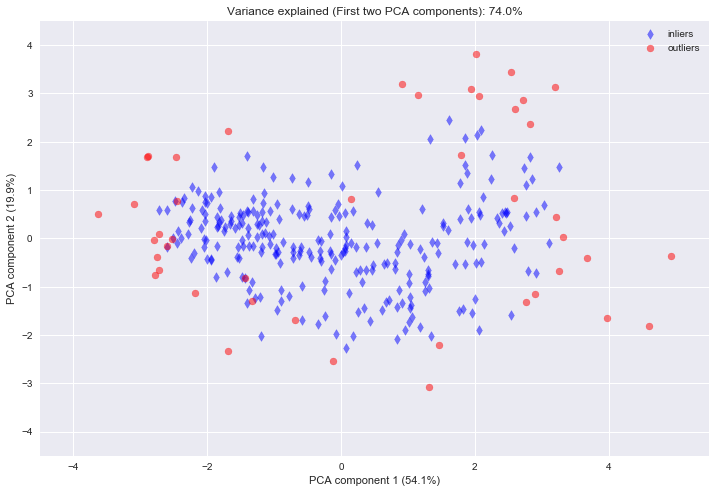

In [82]:
ax = draw_scatter_plot(inliers, outliers, reduced)

In [97]:
assert_is_instance(ax, mpl.axes.Axes, msg="Your function should return a matplotlib.axes.Axes object.")
assert_is_not(len(ax.title.get_text()), 0, msg="Your plot doesn't have a title.")
assert_is_not(ax.xaxis.get_label_text(), '', msg="Change the x-axis label to something more descriptive.")
assert_is_not(ax.yaxis.get_label_text(), '', msg="Change the y-axis label to something more descriptive.")
